# Deploy TensorFlow-hub models on Amazon Sagemaker
# Semantic Text Similarity Example
Blog post Source: https://medium.com/globant/deploy-tensorflow-hub-models-on-amazon-sagemaker-e41c9cc470b5

TFHub Notebook Source (Colab version): https://github.com/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb 

In [1]:
# s3://prj-ml/tfhub-sent-enc/trainingdata/train/
s3_bucket = 'prj-ml' 
prefix = 'tfhub-sent-enc' # model will be saved under this prefix
training_data_prefix = 'trainingdata/train' # training data location

In [69]:
from sagemaker.tensorflow import TensorFlow
from sagemaker.tensorflow.model import TensorFlowModel
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.predictor import JSONSerializer, Predictor, JSONDeserializer
import sagemaker
import time
import boto3
import numpy as np
import seaborn as sns
import tensorflow as tf
import os

In [106]:
!pip3 install seaborn

In [3]:
tf_estimator = TensorFlow(entry_point='encoder.py',
                          role=get_execution_role(),
                          instance_count=1,
                          instance_type='ml.m5.large',
                          framework_version='2.0.0',
                          sagemaker_session=sagemaker.Session(),
                          output_path="s3://{}/{}/".format(
                                                 s3_bucket,prefix),
                          py_version='py3')

In [7]:
train_input = TrainingInput("s3://{}/{}/{}/".format(s3_bucket,prefix,
                                             training_data_prefix), 
                            content_type="text/csv")

In [8]:
job_name = 'sentence-encoder-training-job-' + \
            time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print(job_name)
tf_estimator.fit({"train":train_input}, job_name=job_name)

sentence-encoder-training-job-2021-06-04-20-33-06
2021-06-04 20:33:07 Starting - Starting the training job...
2021-06-04 20:33:31 Starting - Launching requested ML instancesProfilerReport-1622838786: InProgress
......
2021-06-04 20:34:31 Starting - Preparing the instances for training......
2021-06-04 20:35:34 Downloading - Downloading input data...
2021-06-04 20:35:54 Training - Downloading the training image..2021-06-04 20:36:16,238 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-06-04 20:36:16,245 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-06-04 20:36:17,049 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-06-04 20:36:17,066 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-06-04 20:36:17,081 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-06-04 20:36:17,091 sagemaker-containers INFO     Invoking user 

In [14]:
# s3://<bucket_name>/<prefix>/<job_name>/model.tar.gz
# s3://prj-ml/tfhub-sent-enc/sentence-encoder-training-job-2021-06-04-20-33-06/output/model.tar.gz
model_data="s3://{}/{}/{}/output/model.tar.gz".format(
                                         s3_bucket,prefix,job_name)
model_data

's3://prj-ml/tfhub-sent-enc/sentence-encoder-training-job-2021-06-04-20-33-06/output/model.tar.gz'

In [15]:
model = TensorFlowModel(
            model_data=model_data,
            role=get_execution_role(),
            framework_version="2.0.0",
            sagemaker_session=sagemaker.Session())
predictor = model.deploy(initial_instance_count=1, 
                         instance_type='ml.m5.large', 
                         endpoint_name='sentence-encoder-test')
print(predictor.endpoint_name)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!sentence-encoder-test


In [21]:
predictor = Predictor(endpoint_name=predictor.endpoint_name,
                      sagemaker_session=sagemaker.Session(),
                      serializer=JSONSerializer(),
                      deserializer=JSONDeserializer())


In [22]:
result = predictor.predict({'instances': ['hello world', 'I like it']})
print(result)

{'predictions': [[-0.0260742549, -0.0846000165, -0.0267866571, 0.0567842051, 0.0619704388, 0.0382259898, 0.0201149769, 0.0274087321, 0.0869832113, 0.0307918154, 0.041041173, 0.025518328, 0.000965183834, 0.0589279607, 0.0400953963, 0.0467089303, -0.0331279524, 0.0407042, -0.011993004, -0.0476170629, -0.00829667132, 0.0705467537, 0.00484355, 0.0809824765, -0.0570177175, -0.0643551424, 0.069714725, -0.0698838383, 0.026460629, -0.0235220287, 0.0552375428, 0.0491364077, 0.056989722, -0.061071936, 0.0360851139, 0.0232446, 0.0560175143, -0.0109551782, 0.0421308465, -0.0176953785, 0.00712432479, 0.0204703081, -0.071012646, -0.0845577344, 0.0436058342, 0.0479397662, -0.0901802108, -0.0687343776, 0.0127959615, 0.0162498504, -0.0483131036, 0.0308832303, 0.00743837887, 0.0339155868, 0.0332343951, 0.0433182307, 0.0636333674, 0.0492026806, -0.0283108391, 0.00813513342, 0.0613531284, -0.0455091447, 0.072900556, 0.0235105325, 0.0383348, 0.0508494787, 0.00806404464, 0.00862896908, 0.0640241951, -0.0605

# Semantic Similarity
Model served from a SageMaker Endpoint

In [107]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = predictor.predict({'instances': messages_})
  plot_similarity(messages_, message_embeddings_['predictions'], 90)

In [111]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",

    # Politics
    "Modern European politics is dominated by the European Union.",
    "Labour Party achieve between them around 40% of the vote at elections.",

]

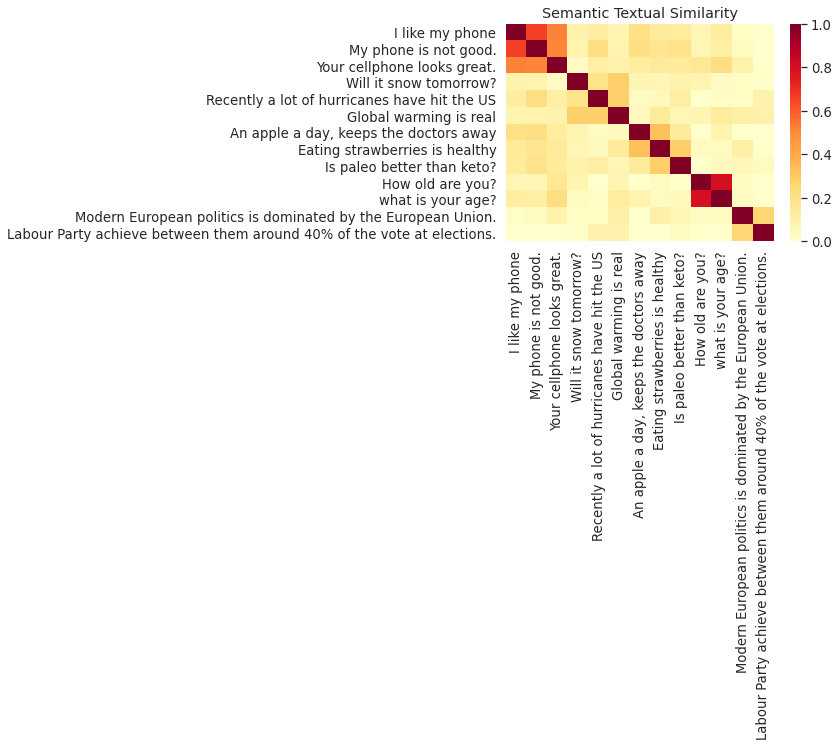

In [112]:
run_and_plot(messages)

## Sentence Similarity

In [ ]:
# !wget http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz
# !tar zxvf 

In [73]:
import pandas
import scipy
import math
import csv

# sts_dataset = tf.keras.utils.get_file(
#     fname="Stsbenchmark.tar.gz",
#     origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
#     extract=True)

sts_dev = pandas.read_table(
#     os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"),
    os.path.join(os.path.dirname('.'), "stsbenchmark", "sts-dev.csv"),
    error_bad_lines=False,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["sim", "sent_1", "sent_2"])
sts_test = pandas.read_table(
#     os.path.join(
#         os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"),
    os.path.join(
        os.path.dirname('.'), "stsbenchmark", "sts-test.csv"),
    error_bad_lines=False,
    quoting=csv.QUOTE_NONE,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["sim", "sent_1", "sent_2"])
# cleanup some NaN values in sts_dev
sts_dev = sts_dev[[isinstance(s, str) for s in sts_dev['sent_2']]]

## STS Dev Data
(base) [ec2-user@ip-172-16-169-178 stsbenchmark]$ head sts-dev.csv
```
main-captions   MSRvid  2012test        0000    5.000   A man with a hard hat is dancing.       A man wearing a hard hat is dancing.
main-captions   MSRvid  2012test        0002    4.750   A young child is riding a horse.        A child is riding a horse.
main-captions   MSRvid  2012test        0003    5.000   A man is feeding a mouse to a snake.    The man is feeding a mouse to the snake.
main-captions   MSRvid  2012test        0007    2.400   A woman is playing the guitar.  A man is playing guitar.
main-captions   MSRvid  2012test        0008    2.750   A woman is playing the flute.   A man is playing a flute.
main-captions   MSRvid  2012test        0010    2.615   A woman is cutting an onion.    A man is cutting onions.
main-captions   MSRvid  2012test        0015    5.000   A man is erasing a chalk board. The man is erasing the chalk board.
```

In [144]:
sts_data = sts_dev #@param ["sts_dev", "sts_test"] {type:"raw"}

def run_sts_benchmark(batch):
#   sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_1'].tolist())), axis=1)
#   sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_2'].tolist())), axis=1)

  xxl = tf.constant(batch['sent_1'].tolist()).numpy().tolist()
  stringlist=[x.decode('utf-8') for x in xxl]
  message_embeddings = predictor.predict({'instances': stringlist})
  sts_encode1 = tf.nn.l2_normalize(message_embeddings['predictions'], axis=1)

  xxl = tf.constant(batch['sent_2'].tolist()).numpy().tolist()
  stringlist=[x.decode('utf-8') for x in xxl]
  message_embeddings = predictor.predict({'instances': stringlist})
  sts_encode2 = tf.nn.l2_normalize(message_embeddings['predictions'], axis=1)

  cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
  clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
  scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi
  """Returns the similarity scores"""
  return scores

dev_scores = sts_data['sim'].tolist()
scores = []
for batch in np.array_split(sts_data, 10):
#   print('Batch: ', batch)
  scores.extend(run_sts_benchmark(batch))

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

Pearson correlation coefficient = 0.803640755652589
p-value = 0.0


## Cleanup

In [ ]:
client = boto3.client('sagemaker')
response = client.delete_endpoint(
                EndpointName=predictor.endpoint_name)
print(response)